# 1. Load Dependencies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset

import pandas as pd
import numpy as np
import time
import datetime
from sys import getsizeof
import ast
import gc
import copy
import os
import joblib

!pip install -q -U torch watermark
%reload_ext watermark

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
%matplotlib inline

Mounted at /content/drive


In [ ]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('Use GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

print('')

%watermark -v -p pandas,numpy,torch,sklearn,matplotlib,seaborn

There are 1 GPU(s) available.
Use GPU: Tesla T4

CPython 3.6.9
IPython 5.5.0

pandas 1.1.2
numpy 1.18.5
torch 1.6.0+cu101
sklearn 0.0
matplotlib 3.2.2
seaborn 0.11.0


# 2. Helper Functions

In [ ]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


def show_memory(unit='MB', threshold='MB'):
    '''check memory usage

    :param unit: memory unit, `B`,`KB`,`MB`,`GB`
    :param threshold: only show memory usage greater than the threshold
    '''
    
    scale = {'B': 1, 'KB': 1024, 'MB': 1048576, 'GB': 1073741824}
    for i in list(globals().keys()):
        memory = eval('getsizeof({})'.format(i))
        if memory >= scale[threshold]:
            print(i, str(memory//scale[unit]) + ' ' + unit)

# 3. Load Data

In [ ]:
# Read data

file_path_train = '/content/drive/My Drive/Colab Notebooks/DATA5703/Preprocessed Data/TrainData_1021.csv'
file_path_test = '/content/drive/My Drive/Colab Notebooks/DATA5703/Preprocessed Data/TestData_1021.csv'

train_df = pd.read_csv(file_path_train)
test_df = pd.read_csv(file_path_test)

data_df = pd.concat([train_df, test_df], ignore_index=True)

data_df.head(1)

,id,userId,gender,sport,duration,calories,distance,avg_heart_rate,longitude,latitude,altitude,timestamp,heart_rate,speed,url,derived_distance,derived_speed,time_elapsed,validate,avg_alti,change_alti,max_alti,min_alti,diff_alti,avg_speed,Cluster,Route,Route_id
0,611012078,2568526,male,run,3158,830.588,10.02,154.914,"[7.099486151710153, 7.0994688011705875, 7.0993...","[43.68301374837756, 43.683006623759866, 43.682...","[137.8, 137.8, 138.2, 138.8, 138.8, 138.6, 139...","[1443653973, 1443653974, 1443653978, 144365398...","[140, 140, 141, 149, 149, 150, 153, 157, 160, ...",NaN,https://www.endomondo.com/users/2568526/workou...,"[0.0016049429213742246, 0.01260242289257531, 0...","[5.777794516947209, 10.005378447215753, 10.428...","[1, 4, 5, 1, 5, 6, 11, 4, 6, 7, 8, 7, 7, 9, 5,...",True,87.8552,756.8,139.4,76.0,63.4,11.574343,1,"('run', 1)",9


In [ ]:
show_memory()

train_df 2492 MB
test_df 623 MB
data_df 3116 MB


In [ ]:
# sequence data was stored in string formatted list
# convert sequence data to array

def str_to_arr(str_ls):
    return np.fromstring(str_ls[1:-1], dtype=np.float, sep=',')


start = time.time()

data_df['heart_rate'] = data_df.apply(
    lambda x: str_to_arr(x['heart_rate']), axis=1)
data_df['altitude'] = data_df.apply(
    lambda x: str_to_arr(x['altitude']), axis=1)
data_df['derived_speed'] = data_df.apply(
    lambda x: str_to_arr(x['derived_speed']), axis=1)
data_df['derived_distance'] = data_df.apply(
    lambda x: str_to_arr(x['derived_distance']), axis=1)
data_df['timestamp'] = data_df.apply(
    lambda x: str_to_arr(x['timestamp']), axis=1)

elapsed = format_time(time.time() - start)
print(elapsed)

0:00:33


In [ ]:
data_df.describe()

,id,userId,duration,calories,distance,avg_heart_rate,avg_alti,change_alti,max_alti,min_alti,diff_alti,avg_speed,Cluster,Route_id
count,6.283100e+04,6.283100e+04,62831.000000,62831.000000,62831.000000,62831.000000,62831.000000,62831.000000,62831.000000,62831.000000,62831.000000,62831.000000,62831.000000,62831.000000
mean,3.679860e+08,4.437249e+06,4237.423151,838.722699,20.815504,142.371731,153.780615,397.032384,189.831314,124.942693,64.888621,17.216757,1.731438,6.528768
std,1.556004e+08,3.856116e+06,2227.567507,514.669974,16.925158,16.141400,254.752939,351.424533,271.461019,245.407699,76.921453,7.959321,1.050199,4.184580
min,1.346435e+06,6.900000e+01,499.000000,100.000000,1.110000,53.778000,-284.491200,0.200000,-261.000000,-500.000000,0.200000,5.010181,0.000000,0.000000
25%,2.640502e+08,1.367691e+06,2680.000000,503.000000,9.950000,132.332000,18.558000,166.600000,40.800000,1.000000,24.000000,10.794519,1.000000,2.000000
50%,3.612350e+08,3.301823e+06,3751.000000,733.000000,14.460000,143.044000,57.592800,285.000000,89.000000,32.800000,43.600000,12.894028,2.000000,9.000000
75%,4.836819e+08,6.692748e+06,5292.000000,1026.000000,26.450000,153.184000,178.990000,509.800000,221.200000,149.050000,74.400000,24.923234,2.000000,10.000000
max,6.675965e+08,1.548142e+07,17848.000000,5569.000000,131.100000,210.194000,1996.081600,2982.000000,2405.200000,1987.400000,999.200000,34.989718,5.000000,13.000000


# 4. Min-Max scaling

In [ ]:
# Load Min-max scaler models

scaler_dic = dict()
features = ['calories', 'distance', 'duration', 'heart_rate',
            'time_elapsed', 'altitude', 'derived_distance', 'speed']

dir = '/content/drive/My Drive/Colab Notebooks/DATA5703/scaler_model/'

for feature in features:
    path = os.path.join(dir, 'scaler_'+feature+'.m')
    scaler_dic[feature] = joblib.load(path)

scaler_dic

{'altitude': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'calories': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'derived_distance': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'distance': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'duration': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'heart_rate': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'speed': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'time_elapsed': MinMaxScaler(copy=True, feature_range=(0, 1))}

In [ ]:
sequence_df = data_df[['altitude', 'heart_rate',
                       'derived_distance', 'derived_speed']].copy()
sequence_df.rename(columns={'derived_speed': 'speed'}, inplace=True)

context_df = data_df[['userId', 'gender', 'sport',
                      'duration', 'calories', 'distance', 'Route_id']].copy()

display(sequence_df.head(1))
display(context_df.head(1))

,altitude,heart_rate,derived_distance,speed
0,"[137.8, 137.8, 138.2, 138.8, 138.8, 138.6, 139...","[140.0, 140.0, 141.0, 149.0, 149.0, 150.0, 153...","[0.0016049429213742246, 0.01260242289257531, 0...","[5.777794516947209, 10.005378447215753, 10.428..."


,userId,gender,sport,duration,calories,distance,Route_id
0,2568526,male,run,3158,830.588,10.02,9


In [ ]:
# Apply min max scaler for each feature

start = time.time()

# for features in sequence_df
for feature in sequence_df.columns:
    # Reshape data using array.reshape(-1, 1) if data has a single feature
    sequence_df[feature] = sequence_df.apply(lambda x: np.concatenate(
        scaler_dic[feature].transform(x[feature].reshape(-1, 1)), axis=0)[0:499], axis=1)

# for features in context_df
for feature in context_df[context_df.columns.difference(['userId', 
                                                         'gender', 
                                                         'sport', 
                                                         'Route_id'])].columns:
    # Reshape data using array.reshape(-1, 1) if data has a single feature
    context_df[feature] = scaler_dic[feature].transform(
        context_df[feature].to_numpy().reshape(-1, 1))


elapsed = format_time(time.time() - start)
print(elapsed)

display(sequence_df.head(1))
display(context_df.head(1))

0:01:06


,altitude,heart_rate,derived_distance,speed
0,"[0.21051532033426185, 0.21051532033426185, 0.2...","[0.5833333333333334, 0.5833333333333334, 0.587...","[0.0008705472935918672, 0.006835760322515244, ...","[0.05777888189652973, 0.10005540659781222, 0.1..."


,userId,gender,sport,duration,calories,distance,Route_id
0,2568526,male,run,0.153265,0.129684,0.06044,9


In [ ]:
data_df = pd.concat([context_df, sequence_df, data_df[['timestamp']]], axis=1)

data_df.head(1)

,userId,gender,sport,duration,calories,distance,Route_id,altitude,heart_rate,derived_distance,speed,timestamp
0,2568526,male,run,0.153265,0.129684,0.06044,9,"[0.21051532033426185, 0.21051532033426185, 0.2...","[0.5833333333333334, 0.5833333333333334, 0.587...","[0.0008705472935918672, 0.006835760322515244, ...","[0.05777888189652973, 0.10005540659781222, 0.1...","[1443653973.0, 1443653974.0, 1443653978.0, 144..."


# 5. Process data to construct features for User Embedding Training

In [ ]:
# construct user profile, which will be used in visualisation of entity embeddings

# Count workout numbers and workout frequency for each user

def get_freq_from_ts(ts_list):

    deltas = []

    ts_list.sort()
    for i, ts in enumerate(ts_list):
        if i == 0:
            pass
        else:
            ts_prev = ts_list[i-1]

            dt_prev = datetime.datetime.fromtimestamp(ts_prev).date()
            dt = datetime.datetime.fromtimestamp(ts).date()

            deltas.append(abs(dt-dt_prev).days)
    try:
        if (len(deltas) == 1) & (sum(deltas) == 0):
            return 0
        else:
            return 1./(sum(deltas)/len(deltas))
    except:
        print('deltas: ', deltas)
        raise


start = time.time()

userlist = data_df.userId.unique().tolist()
print('There are {} users.'.format(len(userlist)))

user_profile = []

for user in userlist:
    time_stamps_list = data_df[data_df.userId == user].timestamp.tolist()
    time_stamp_list = [time_stamps[0] for time_stamps in time_stamps_list]
    gender = data_df[data_df.userId == user].gender.iloc[0]
    records = len(time_stamp_list)
    if records > 1:
        user_profile.append([user,
                             records,
                             get_freq_from_ts(time_stamp_list)])
    else:
        user_profile.append([user,
                             1,
                             0])

user_profile_df = pd.DataFrame(
    user_profile, columns=['userId', 'workout_records', 'workout_freq'])

elapsed = format_time(time.time() - start)
print(elapsed)

user_profile_df.head(1)

There are 929 users.
0:00:02


,userId,workout_records,workout_freq
0,2568526,225,0.24086


In [ ]:
# Compute avg_calories, avg_speed, avg_distance for each user

user_profile_list = []

for user in userlist:

    avg_calories = data_df[data_df.userId == user].calories.mean()
    avg_distance = data_df[data_df.userId == user].distance.mean()
    avg_speed = data_df[data_df.userId == user].apply(
        lambda x: x.speed.mean(), axis=1).mean()

    user_arr = np.array([user,
                         avg_calories,
                         avg_speed,
                         avg_distance])

    user_profile_list.append(user_arr)

user_df = pd.DataFrame(user_profile_list, columns=['userId',
                                                   'avg_calories',
                                                   'avg_speed',
                                                   'avg_distance'])
user_df.head(1)

,userId,avg_calories,avg_speed,avg_distance
0,2568526.0,0.152706,0.160723,0.148586


In [ ]:
# Add additional features to user_profile_df

user_profile_df = user_profile_df.join(
    user_df.set_index('userId'), how='left', on='userId')

user_profile_df.head(1)

,userId,workout_records,workout_freq,avg_calories,avg_speed,avg_distance
0,2568526,225,0.24086,0.152706,0.160723,0.148586


In [ ]:
# Add workout numbers and workout frequency to data_df
start = time.time()

data_df['workout_records'] = data_df.apply(
    lambda x: user_profile_df[user_profile_df.userId == x.userId].workout_records.values[0], axis=1)
data_df['workout_freq'] = data_df.apply(
    lambda x: user_profile_df[user_profile_df.userId == x.userId].workout_freq.values[0], axis=1)

elapsed = format_time(time.time() - start)
print(elapsed)

data_df.head(1)

0:01:00


,userId,gender,sport,duration,calories,distance,Route_id,altitude,heart_rate,derived_distance,speed,timestamp,workout_records,workout_freq
0,2568526,male,run,0.153265,0.129684,0.06044,9,"[0.21051532033426185, 0.21051532033426185, 0.2...","[0.5833333333333334, 0.5833333333333334, 0.587...","[0.0008705472935918672, 0.006835760322515244, ...","[0.05777888189652973, 0.10005540659781222, 0.1...","[1443653973.0, 1443653974.0, 1443653978.0, 144...",225,0.24086


In [ ]:
# Scale workout_records and workout_freq

scaler_dic = {}

scaler_workout_records = MinMaxScaler()
scaler_workout_freq = MinMaxScaler()

scaler_workout_records.fit(data_df.workout_records.to_numpy().reshape(-1, 1))
scaler_workout_freq.fit(data_df.workout_freq.to_numpy().reshape(-1, 1))

data_df['workout_records'] = scaler_workout_records.transform(
    data_df.workout_records.to_numpy().reshape(-1, 1)).reshape(1, -1)[0]
data_df['workout_freq'] = scaler_workout_freq.transform(
    data_df.workout_freq.to_numpy().reshape(-1, 1)).reshape(1, -1)[0]

In [ ]:
# Compute some parameters from sequence data

start = time.time()

data_df['min_altitude'] = data_df.apply(lambda x: np.amin(x.altitude), axis=1)
data_df['avg_altitude'] = data_df.apply(lambda x: x.altitude.mean(), axis=1)
data_df['max_altitude'] = data_df.apply(lambda x: np.amax(x.altitude), axis=1)

data_df['min_heart_rate'] = data_df.apply(
    lambda x: np.amin(x.heart_rate), axis=1)
data_df['avg_heart_rate'] = data_df.apply(
    lambda x: x.heart_rate.mean(), axis=1)
data_df['max_heart_rate'] = data_df.apply(
    lambda x: np.amax(x.heart_rate), axis=1)

data_df['min_distance'] = data_df.apply(
    lambda x: np.amin(x.derived_distance), axis=1)
data_df['avg_distance'] = data_df.apply(
    lambda x: x.derived_distance.mean(), axis=1)
data_df['max_distance'] = data_df.apply(
    lambda x: np.amax(x.derived_distance), axis=1)

data_df['min_speed'] = data_df.apply(lambda x: np.amin(x.speed), axis=1)
data_df['avg_speed'] = data_df.apply(lambda x: x.speed.mean(), axis=1)
data_df['max_speed'] = data_df.apply(lambda x: np.amax(x.speed), axis=1)

elapsed = format_time(time.time() - start)
print(elapsed)

0:00:13


In [ ]:
# Encode gender feature

conditions = [
    (data_df['gender'] == 'male'),
    (data_df['gender'] == 'female'),
    (data_df['gender'] == 'unknown')]

choices = [0, 1, 2]

data_df['genderId'] = np.select(conditions, choices, default=0)

In [ ]:
# Encode sport feature

conditions = [
    (data_df['sport'] == 'run'),
    (data_df['sport'] == 'bike'),
    (data_df['sport'] == 'mountain bike')]

choices = [0, 1, 2]

data_df['sportId'] = np.select(conditions, choices, default=0)

In [ ]:
data_df.head(1)

,userId,gender,sport,duration,calories,distance,Route_id,altitude,heart_rate,derived_distance,speed,timestamp,workout_records,workout_freq,min_altitude,avg_altitude,max_altitude,min_heart_rate,avg_heart_rate,max_heart_rate,min_distance,avg_distance,max_distance,min_speed,avg_speed,max_speed,genderId,sportId
0,2568526,male,run,0.153265,0.129684,0.06044,9,"[0.21051532033426185, 0.21051532033426185, 0.2...","[0.5833333333333334, 0.5833333333333334, 0.587...","[0.0008705472935918672, 0.006835760322515244, ...","[0.05777888189652973, 0.10005540659781222, 0.1...","[1443653973.0, 1443653974.0, 1443653978.0, 144...",0.270531,0.333499,0.188997,0.193092,0.211072,0.316667,0.645316,0.783333,0.000871,0.01089,0.024076,0.057779,0.115745,0.156878,0,0


In [ ]:
# Remove irrelevant features

data_df = data_df[['userId',
                   'duration',
                   'calories',
                   'distance',
                   'Route_id',
                   'min_altitude',
                   'avg_altitude',
                   'max_altitude',
                   'min_heart_rate',
                   'avg_heart_rate',
                   'max_heart_rate',
                   'min_distance',
                   'avg_distance',
                   'max_distance',
                   'min_speed',
                   'avg_speed',
                   'max_speed',
                   'genderId',
                   'sportId',
                   'workout_records',
                   'workout_freq']]


In [ ]:
# Onehot encoding of selected features

data_df = pd.get_dummies(data_df, prefix=['gender', 'sport'], columns=[
                         'genderId', 'sportId'])
data_df.head(1)

,userId,duration,calories,distance,Route_id,min_altitude,avg_altitude,max_altitude,min_heart_rate,avg_heart_rate,max_heart_rate,min_distance,avg_distance,max_distance,min_speed,avg_speed,max_speed,workout_records,workout_freq,gender_0,gender_1,gender_2,sport_0,sport_1,sport_2
0,2568526,0.153265,0.129684,0.06044,9,0.188997,0.193092,0.211072,0.316667,0.645316,0.783333,0.000871,0.01089,0.024076,0.057779,0.115745,0.156878,0.270531,0.333499,1,0,0,1,0,0


In [ ]:
data_df.describe()

,userId,duration,calories,distance,Route_id,min_altitude,avg_altitude,max_altitude,min_heart_rate,avg_heart_rate,max_heart_rate,min_distance,avg_distance,max_distance,min_speed,avg_speed,max_speed,workout_records,workout_freq,gender_0,gender_1,gender_2,sport_0,sport_1,sport_2
count,6.283100e+04,62831.000000,62831.000000,62831.000000,62831.000000,62831.000000,62831.000000,62831.000000,62831.000000,62831.000000,62831.000000,62831.000000,62831.000000,62831.000000,62831.000000,62831.000000,62831.000000,62831.000000,62831.000000,62831.000000,62831.000000,62831.000000,62831.000000,62831.000000,62831.000000
mean,4.437249e+06,0.215483,0.131128,0.133181,6.528768,0.206047,0.216082,0.228623,0.363247,0.593240,0.692267,0.002509,0.022627,0.059414,0.043376,0.172170,0.302070,0.235450,0.252568,0.940507,0.050341,0.009152,0.566631,0.380513,0.052856
std,3.856116e+06,0.128397,0.091357,0.114043,4.184580,0.085454,0.088706,0.094515,0.077204,0.067226,0.073319,0.003917,0.018398,0.049689,0.035798,0.079595,0.191825,0.208409,0.178091,0.236547,0.218650,0.095226,0.495544,0.485517,0.223748
min,6.900000e+01,0.000000,0.000000,0.000404,0.000000,-0.011560,0.063471,0.071657,0.008333,0.223530,0.300000,0.000000,0.001201,0.003117,0.000000,0.050103,0.065576,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.367691e+06,0.125713,0.071535,0.059969,2.000000,0.162883,0.168998,0.176741,0.308333,0.551428,0.645833,0.000152,0.010819,0.024744,0.008062,0.107947,0.136828,0.084541,0.118132,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.301823e+06,0.187446,0.112362,0.090357,9.000000,0.174023,0.182585,0.193524,0.354167,0.596059,0.691667,0.001056,0.015720,0.037404,0.040072,0.128942,0.187344,0.181159,0.214986,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,6.692748e+06,0.276270,0.164371,0.171147,10.000000,0.214450,0.224856,0.239485,0.408333,0.638260,0.733333,0.003233,0.028750,0.078687,0.072128,0.249236,0.462982,0.316425,0.345780,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.548142e+07,1.000000,0.970784,0.876284,13.000000,0.854596,0.857556,1.000000,0.808333,0.875860,1.000000,0.058300,0.142502,1.031966,0.273424,0.349903,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# Create a dictionary to map userId to user index

user_list = data_df.userId.unique().tolist()
user_list.sort()
user_list_size = len(user_list)

# get userId and userId index in user_list and save in dictionary where userId is key
userId_idx = {userId: idx for idx, userId in enumerate(user_list)}

# 6. Construct Torch Dataset

In [ ]:
class FitRecUserEmbedData(Dataset):
    def __init__(self, df):
        self.df = df

	# return a data sample
    def __getitem__(self, idx): 
        
        label = self.df.iloc[idx].Route_id
        data = self.df[self.df.columns.difference(['userId', 'Route_id'])].iloc[idx].to_numpy()
        # ensure userId is at index 0
        data = np.hstack((self.df.iloc[idx].userId, data))

        label = torch.tensor(label)
        data = torch.tensor(data)
        
        return data, label

    def __len__(self):
        return len(self.df)

In [ ]:
# train test split

data_df_train, data_df_val = train_test_split(
    data_df, test_size=0.2, random_state=42)

user_embed_ds_train = FitRecUserEmbedData(data_df_train)
user_embed_dl_train = torch.utils.data.DataLoader(user_embed_ds_train,
                                                  batch_size=32,
                                                  shuffle=True,
                                                  drop_last=True)

user_embed_ds_val = FitRecUserEmbedData(data_df_val)
user_embed_dl_val = torch.utils.data.DataLoader(user_embed_ds_val,
                                                 batch_size=32,
                                                 shuffle=True,
                                                 drop_last=True)

# 7. Define User Embedding Traing Model

In [ ]:
class UserEmbedding(nn.Module):
    def __init__(self, user_list_size, embed_size, context_size, num_class):
        super(UserEmbedding, self).__init__()

        # we have a layer mapping user to embedding (hidden layer)
        self.user_embed_layer = nn.Embedding(user_list_size, embed_size)

        # we have another layer projecting hidden layer to output layer
        self.linear = nn.Linear(embed_size+context_size, num_class)

    def forward(self, user_idx, context):
        user_embedding = self.user_embed_layer(user_idx.to(device))
        hidden = torch.cat((user_embedding, context), dim=1).float()

        output = self.linear(hidden)
        # output = F.softmax(output, dim=1)

        return output

# 8. Define functions to save model and train model

In [ ]:
def save_model(filename, model,
               best_epoch,
               best_loss_train,
               lowest_loss_val,
               best_F1_train,
               best_F1_val,
               epochs,
               total_losses_train,
               total_losses_val,
               total_F1_train,
               total_F1_val):

    DATA_PATH = "/content/drive/My Drive/Colab Notebooks/DATA5703/Entity Embedding/"+filename
    state = {
        'model_state_dict': model,
        'best_epoch': best_epoch,
        'best_loss_train': best_loss_train,
        'lowest_loss_val': lowest_loss_val,
        'best_F1_train': best_F1_train,
        'best_F1_val': best_F1_val,
        'epochs': epochs,
        'total_losses_train': total_losses_train,
        'total_losses_val': total_losses_val,
        'total_F1_train': total_F1_train,
        'total_F1_val': total_F1_val
    }
    torch.save(state, DATA_PATH)


def UserEmbedding_train(model,
                        optimiser,
                        criterion,
                        num_epochs,
                        dl_train,
                        dl_val,
                        userId_idx,
                        show_progress_epoch,
                        save_model_epoch,
                        save_model_name):

    checkpoint = time.time()

    epochs = []
    total_losses_train = []
    total_losses_val = []
    total_F1_train = []
    total_F1_val = []

    # iterate over number of epochs

    for epoch in range(1, num_epochs+1):

        check_epoch = time.time()

        # update epoch record
        epochs.append(epoch)

        # Training:
        # create empty list to save training loss for each epoch
        train_losses_epoch = []
        # create torch tensor to save training model predictions for each epoch
        # this is needed because training data was split into mini-batches
        train_preds_epoch = torch.zeros(0, dtype=torch.long, device='cpu')
        # create torch tensor to save training labels for each epoch
        # this is needed because training data was split into mini-batches
        train_labels_epoch = torch.zeros(0, dtype=torch.long, device='cpu')

        lowest_loss_val = 10000.

        # iterate over mini-batches

        for data_batch_train, label_batch_train in dl_train:
            data_batch_train = data_batch_train.to(device)
            label_batch_train = label_batch_train.long().to(device)

            userIds = data_batch_train[:, 0].long()
            context_feat = data_batch_train[:, 1:]

            user_idx = [userId_idx[id] for id in userIds.tolist()]
            user_idx = torch.LongTensor(user_idx)

            # model training
            model.train()
            optimiser.zero_grad()

            output = model(user_idx, context_feat)

            loss = criterion(output, label_batch_train).sum()

            loss.backward()
            optimiser.step()

            # store mini-batch loss
            train_losses_epoch.append(loss.item())

            # get model predictions for the mini-batch and save prediction and label
            # they will be later used to compute F1 Score for the epoch

            with torch.no_grad():
                output = F.softmax(output, dim=1)

                preds = torch.argmax(output, 1)

                labels = label_batch_train

                train_preds_epoch = torch.cat(
                    [train_preds_epoch, preds.view(-1).cpu()])
                train_labels_epoch = torch.cat(
                    [train_labels_epoch, labels.view(-1).cpu()])

        # get average training loss for the epoch over mini-batches
        train_losses_epoch = np.average(train_losses_epoch)

        # add training loss of epoch to total training loss list
        total_losses_train.append(train_losses_epoch)

        # compute training F1 score of epoch
        train_F1_epoch = f1_score(train_labels_epoch.numpy(
        ), train_preds_epoch.numpy(), average='weighted')
        # add training F1 score of epoch to training F1 score list
        total_F1_train.append(train_F1_epoch)

        # Validation:

        # create empty list to save val loss for each epoch
        val_losses_epoch = []
        # create torch tensor to save val model predictions for each epoch
        # this is needed because val data was split into mini-batches
        val_preds_epoch = torch.zeros(0, dtype=torch.long, device='cpu')
        # create torch tensor to save val labels for each epoch
        # this is needed because val data was split into mini-batches
        val_labels_epoch = torch.zeros(0, dtype=torch.long, device='cpu')

        for data_batch_val, label_batch_val in dl_val:
            data_batch_val = data_batch_val.to(device)
            label_batch_val = label_batch_val.long().to(device)

            userIds = data_batch_val[:, 0].long()
            context_feat = data_batch_val[:, 1:]
            user_idx = [userId_idx[id] for id in userIds.tolist()]
            user_idx = torch.LongTensor(user_idx)

            model.eval()

            # get model predictions for the mini-batch and save prediction and label
            # they will be later used to compute F1 Score for the epoch

            with torch.no_grad():
                output = model(user_idx, context_feat)
                loss = criterion(output, label_batch_val).sum()

                output = F.softmax(output, dim=1)
                preds = torch.argmax(output, 1)
                labels = label_batch_val

                val_preds_epoch = torch.cat(
                    [val_preds_epoch, preds.view(-1).cpu()])
                val_labels_epoch = torch.cat(
                    [val_labels_epoch, labels.view(-1).cpu()])

            val_losses_epoch.append(loss.item())

        # get average val loss for the epoch over mini-batches
        val_losses_epoch = np.average(val_losses_epoch)
        # add val loss of epoch to total val loss list
        total_losses_val.append(val_losses_epoch)

        # compute val F1 score of epoch
        val_F1_epoch = f1_score(val_labels_epoch.numpy(
        ), val_preds_epoch.numpy(), average='weighted')
        # add val F1 score of epoch to val F1 score list
        total_F1_val.append(val_F1_epoch)

        elapsed_epoch = format_time(time.time() - check_epoch)

        # show training progress at pre-defined interval
        if epoch % show_progress_epoch == show_progress_epoch-1:
            print('Epoch: {} Elapsed {} | Train Loss: {:.4} | Val Loss: {:.4} | Train F1: {:.1%} | Val F1: {:.1%}'.format(
                epoch, elapsed_epoch, train_losses_epoch, val_losses_epoch, train_F1_epoch, val_F1_epoch))

        # save best model
        if val_losses_epoch < lowest_loss_val:
            lowest_loss_val = val_losses_epoch
            best_epoch = epoch
            best_F1_train = train_F1_epoch
            best_F1_val = val_F1_epoch
            best_loss_train = train_losses_epoch
            best_model_wts = copy.deepcopy(model.state_dict())

        # save model during training at pre-defined interval
        if epoch % save_model_epoch == save_model_epoch - 1:

            save_model(save_model_name,
                       best_model_wts,
                       best_epoch,
                       best_loss_train,
                       lowest_loss_val,
                       best_F1_train,
                       best_F1_val,
                       epochs,
                       total_losses_train,
                       total_losses_val,
                       total_F1_train,
                       total_F1_val
                       )

    elapsed = format_time(time.time() - checkpoint)
    print('Training complete in: ', elapsed)

# 9. Train Model

## 9.1 Train model with USER_EMBED_SIZE=2

In [ ]:
# Build model instance and train model

USER_EMBED_SIZE = 2
NUM_CLASS = 14
LEARNING_RATE = 0.01
NUM_EPOCHS = 50
SHOW_PROGRESS_EPOCH = 1
SAVE_MODEL_EPOCH = 1
SAVE_MODEL_NAME = 'UserEmbed_Super_2'

context_feat_size = data_df.shape[1]-2

UserEmbed = UserEmbedding(user_list_size,
                          USER_EMBED_SIZE,
                          context_feat_size,
                          NUM_CLASS).to(device)

optimiser = torch.optim.Adam(UserEmbed.parameters(), lr=LEARNING_RATE)

criterion = nn.CrossEntropyLoss()

UserEmbedding_train(
    UserEmbed,
    optimiser,
    criterion,
    NUM_EPOCHS,
    user_embed_dl_train,
    user_embed_dl_val,
    userId_idx,
    SHOW_PROGRESS_EPOCH,
    SAVE_MODEL_EPOCH,
    SAVE_MODEL_NAME
)

Epoch: 1 Elapsed 0:02:34 | Train Loss: 0.7516 | Val Loss: 0.4861 | Train F1: 72.3% | Val F1: 81.8%
Epoch: 2 Elapsed 0:02:31 | Train Loss: 0.4274 | Val Loss: 0.3967 | Train F1: 84.2% | Val F1: 85.6%
Epoch: 3 Elapsed 0:02:29 | Train Loss: 0.3693 | Val Loss: 0.3603 | Train F1: 86.3% | Val F1: 86.4%
Epoch: 4 Elapsed 0:02:19 | Train Loss: 0.3405 | Val Loss: 0.3381 | Train F1: 87.4% | Val F1: 86.7%
Epoch: 5 Elapsed 0:02:16 | Train Loss: 0.3217 | Val Loss: 0.3241 | Train F1: 87.9% | Val F1: 87.8%
Epoch: 6 Elapsed 0:02:17 | Train Loss: 0.3083 | Val Loss: 0.3167 | Train F1: 88.4% | Val F1: 88.0%
Epoch: 7 Elapsed 0:02:16 | Train Loss: 0.2967 | Val Loss: 0.3039 | Train F1: 88.7% | Val F1: 88.5%
Epoch: 8 Elapsed 0:02:16 | Train Loss: 0.2877 | Val Loss: 0.2989 | Train F1: 89.1% | Val F1: 88.8%
Epoch: 9 Elapsed 0:02:15 | Train Loss: 0.2804 | Val Loss: 0.2905 | Train F1: 89.4% | Val F1: 88.7%
Epoch: 10 Elapsed 0:02:18 | Train Loss: 0.2735 | Val Loss: 0.289 | Train F1: 89.5% | Val F1: 88.7%
Epoch: 11 

## 9.2 Train model with USER_EMBED_SIZE=4

In [ ]:
# Build model instance and train model

USER_EMBED_SIZE = 4
NUM_CLASS = 14
LEARNING_RATE = 0.01
NUM_EPOCHS = 50
SHOW_PROGRESS_EPOCH = 1
SAVE_MODEL_EPOCH = 1
SAVE_MODEL_NAME = 'UserEmbed_Super_4'

context_feat_size = data_df.shape[1]-2

UserEmbed = UserEmbedding(user_list_size,
                          USER_EMBED_SIZE,
                          context_feat_size,
                          NUM_CLASS).to(device)

optimiser = torch.optim.Adam(UserEmbed.parameters(), lr=LEARNING_RATE)

criterion = nn.CrossEntropyLoss()

UserEmbedding_train(
    UserEmbed,
    optimiser,
    criterion,
    NUM_EPOCHS,
    user_embed_dl_train,
    user_embed_dl_val,
    userId_idx,
    SHOW_PROGRESS_EPOCH,
    SAVE_MODEL_EPOCH,
    SAVE_MODEL_NAME
)

Epoch: 1 Elapsed 0:02:37 | Train Loss: 0.6852 | Val Loss: 0.4331 | Train F1: 75.0% | Val F1: 84.0%
Epoch: 2 Elapsed 0:02:25 | Train Loss: 0.3878 | Val Loss: 0.3686 | Train F1: 85.5% | Val F1: 86.4%
Epoch: 3 Elapsed 0:02:25 | Train Loss: 0.3417 | Val Loss: 0.3397 | Train F1: 87.1% | Val F1: 87.5%
Epoch: 4 Elapsed 0:02:23 | Train Loss: 0.3164 | Val Loss: 0.3223 | Train F1: 88.0% | Val F1: 88.0%
Epoch: 5 Elapsed 0:02:21 | Train Loss: 0.2993 | Val Loss: 0.314 | Train F1: 88.6% | Val F1: 87.6%
Epoch: 6 Elapsed 0:02:21 | Train Loss: 0.2866 | Val Loss: 0.303 | Train F1: 89.0% | Val F1: 88.3%
Epoch: 7 Elapsed 0:02:29 | Train Loss: 0.2769 | Val Loss: 0.2945 | Train F1: 89.3% | Val F1: 88.4%
Epoch: 8 Elapsed 0:02:23 | Train Loss: 0.269 | Val Loss: 0.2883 | Train F1: 89.7% | Val F1: 88.8%
Epoch: 9 Elapsed 0:02:24 | Train Loss: 0.2621 | Val Loss: 0.2891 | Train F1: 89.8% | Val F1: 89.0%
Epoch: 10 Elapsed 0:02:23 | Train Loss: 0.2568 | Val Loss: 0.2826 | Train F1: 90.1% | Val F1: 89.1%
Epoch: 11 El

## 9.3 Train model with USER_EMBED_SIZE=13

In [ ]:
# Build model instance and train model

USER_EMBED_SIZE = 13
NUM_CLASS = 14
LEARNING_RATE = 0.01
NUM_EPOCHS = 50
SHOW_PROGRESS_EPOCH = 1
SAVE_MODEL_EPOCH = 1
SAVE_MODEL_NAME = 'UserEmbed_Super_13'

context_feat_size = data_df.shape[1]-2

UserEmbed = UserEmbedding(user_list_size,
                          USER_EMBED_SIZE,
                          context_feat_size,
                          NUM_CLASS).to(device)

optimiser = torch.optim.Adam(UserEmbed.parameters(), lr=LEARNING_RATE)

criterion = nn.CrossEntropyLoss()

UserEmbedding_train(
    UserEmbed,
    optimiser,
    criterion,
    NUM_EPOCHS,
    user_embed_dl_train,
    user_embed_dl_val,
    userId_idx,
    SHOW_PROGRESS_EPOCH,
    SAVE_MODEL_EPOCH,
    SAVE_MODEL_NAME
)

Epoch: 1 Elapsed 0:02:16 | Train Loss: 0.6457 | Val Loss: 0.4341 | Train F1: 76.9% | Val F1: 82.9%
Epoch: 2 Elapsed 0:02:20 | Train Loss: 0.3796 | Val Loss: 0.365 | Train F1: 85.8% | Val F1: 86.2%
Epoch: 3 Elapsed 0:02:18 | Train Loss: 0.3339 | Val Loss: 0.3361 | Train F1: 87.4% | Val F1: 87.1%
Epoch: 4 Elapsed 0:02:13 | Train Loss: 0.3098 | Val Loss: 0.3211 | Train F1: 88.2% | Val F1: 87.9%
Epoch: 5 Elapsed 0:02:20 | Train Loss: 0.2941 | Val Loss: 0.3174 | Train F1: 88.7% | Val F1: 87.8%
Epoch: 6 Elapsed 0:02:14 | Train Loss: 0.2832 | Val Loss: 0.3089 | Train F1: 89.0% | Val F1: 87.7%
Epoch: 7 Elapsed 0:02:17 | Train Loss: 0.2743 | Val Loss: 0.3039 | Train F1: 89.3% | Val F1: 88.4%
Epoch: 8 Elapsed 0:02:18 | Train Loss: 0.2673 | Val Loss: 0.2989 | Train F1: 89.7% | Val F1: 88.7%
Epoch: 9 Elapsed 0:02:15 | Train Loss: 0.2622 | Val Loss: 0.2936 | Train F1: 89.9% | Val F1: 88.5%
Epoch: 10 Elapsed 0:02:20 | Train Loss: 0.2561 | Val Loss: 0.2826 | Train F1: 90.1% | Val F1: 89.4%
Epoch: 11 

## 9.4 Train model with USER_EMBED_SIZE=17

In [ ]:
# Build model instance and train model

USER_EMBED_SIZE = 17
NUM_CLASS = 14
LEARNING_RATE = 0.01
NUM_EPOCHS = 50
SHOW_PROGRESS_EPOCH = 1
SAVE_MODEL_EPOCH = 1
SAVE_MODEL_NAME = 'UserEmbed_Super_17'

context_feat_size = data_df.shape[1]-2

UserEmbed = UserEmbedding(user_list_size,
                          USER_EMBED_SIZE,
                          context_feat_size,
                          NUM_CLASS).to(device)

optimiser = torch.optim.Adam(UserEmbed.parameters(), lr=LEARNING_RATE)

criterion = nn.CrossEntropyLoss()

UserEmbedding_train(
    UserEmbed,
    optimiser,
    criterion,
    NUM_EPOCHS,
    user_embed_dl_train,
    user_embed_dl_val,
    userId_idx,
    SHOW_PROGRESS_EPOCH,
    SAVE_MODEL_EPOCH,
    SAVE_MODEL_NAME
)

Epoch: 1 Elapsed 0:02:28 | Train Loss: 0.6509 | Val Loss: 0.425 | Train F1: 76.9% | Val F1: 84.1%
Epoch: 2 Elapsed 0:02:32 | Train Loss: 0.3813 | Val Loss: 0.3636 | Train F1: 85.7% | Val F1: 86.3%
Epoch: 3 Elapsed 0:02:25 | Train Loss: 0.3357 | Val Loss: 0.3349 | Train F1: 87.2% | Val F1: 87.4%
Epoch: 4 Elapsed 0:02:32 | Train Loss: 0.312 | Val Loss: 0.3254 | Train F1: 88.1% | Val F1: 87.2%
Epoch: 5 Elapsed 0:02:32 | Train Loss: 0.2966 | Val Loss: 0.3233 | Train F1: 88.6% | Val F1: 88.0%
Epoch: 6 Elapsed 0:02:31 | Train Loss: 0.2858 | Val Loss: 0.314 | Train F1: 88.9% | Val F1: 87.9%
Epoch: 7 Elapsed 0:02:31 | Train Loss: 0.277 | Val Loss: 0.307 | Train F1: 89.3% | Val F1: 88.8%
Epoch: 8 Elapsed 0:02:29 | Train Loss: 0.2711 | Val Loss: 0.2965 | Train F1: 89.4% | Val F1: 88.7%
Epoch: 9 Elapsed 0:02:27 | Train Loss: 0.2646 | Val Loss: 0.295 | Train F1: 89.8% | Val F1: 89.0%
Epoch: 10 Elapsed 0:02:25 | Train Loss: 0.2591 | Val Loss: 0.2878 | Train F1: 89.9% | Val F1: 89.0%
Epoch: 11 Elaps

# 10. Load Trained Model and Training Log

In [ ]:
# Define function to load model

def load_model(filename, model):

    DATA_PATH = "/content/drive/My Drive/Colab Notebooks/DATA5703/Entity Embedding/"+filename

    checkpoint = torch.load(DATA_PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    best_epoch = checkpoint['best_epoch']
    best_loss_train = checkpoint['best_loss_train']
    lowest_loss_val = checkpoint['lowest_loss_val']
    best_F1_train = checkpoint['best_F1_train']
    best_F1_val = checkpoint['best_F1_val']
    epochs = checkpoint['epochs']
    total_losses_train = checkpoint['total_losses_train']
    total_losses_val = checkpoint['total_losses_val']
    total_F1_train = checkpoint['total_F1_train']
    total_F1_val = checkpoint['total_F1_val']

    return model, best_epoch, best_loss_train, lowest_loss_val, best_F1_train, \
        best_F1_val, epochs, total_losses_train, total_losses_val, total_F1_train, \
        total_F1_val

In [ ]:
# Define function to visualise training log

def train_log_visual(loss_df, f1_df, embed_size, best_epoch):
    fig, axes = plt.subplots(1, 2, figsize=(18, 6), dpi=90)
    fig.suptitle('Training Log (Embed_Size=' + str(embed_size) + ')', fontsize=20)
    sns.lineplot(data=loss_df, x='Epochs', y='Loss', hue='Type', ax=axes[0])
    sns.lineplot(data=f1_df, x='Epochs', y='F1', hue='Type', ax=axes[1])

    axes[0].set_title('Loss vs Epochs')
    axes[1].set_title('F1 Score vs Epochs')

    for ax in axes:
        ax.set_xlabel('Epochs', fontsize=15)
        ax.set_ylabel('Loss', fontsize=15)
        ax.legend(loc='lower left',
                    title=ax.get_legend().get_title().get_text(),
                    fontsize='small')

## 10.1 Load Model with USER_EMBED_SIZE=2

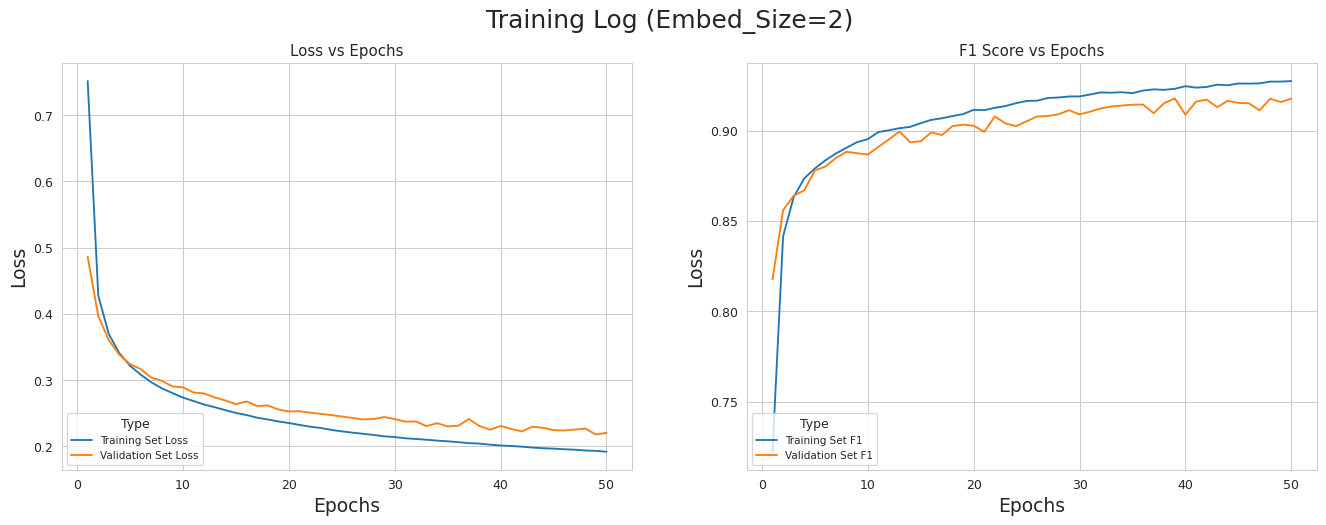

In [ ]:
# Define new model instance

USER_EMBED_SIZE = 2
NUM_CLASS = 14
LOAD_MODEL_NAME = 'UserEmbed_Super_2'
context_feat_size = data_df.shape[1]-2

UserEmbed_Super_2 = UserEmbedding(user_list_size,
                            USER_EMBED_SIZE,
                            context_feat_size,
                            NUM_CLASS).to(device)

# Load model from Google Drive

UserEmbed_Super_2, best_epoch, best_loss_train, lowest_loss_val, best_F1_train, \
    best_F1_val, epochs, total_losses_train, total_losses_val, total_F1_train, \
    total_F1_val = load_model(LOAD_MODEL_NAME, UserEmbed_Super_2)


# Save training log to dataframe format

train_loss_df = pd.DataFrame(zip(epochs, total_losses_train), columns=[
    'Epochs', 'Loss'])
train_loss_df['Type'] = 'Training Set Loss'
val_loss_df = pd.DataFrame(zip(epochs, total_losses_val), columns=[
    'Epochs', 'Loss'])
val_loss_df['Type'] = 'Validation Set Loss'
loss_df = pd.concat([train_loss_df, val_loss_df], axis=0)


train_f1_df = pd.DataFrame(zip(epochs, total_F1_train), columns=[
    'Epochs', 'F1'])
train_f1_df['Type'] = 'Training Set F1'
val_f1_df = pd.DataFrame(zip(epochs, total_F1_val), columns=[
    'Epochs', 'F1'])
val_f1_df['Type'] = 'Validation Set F1'
f1_df = pd.concat([train_f1_df, val_f1_df], axis=0)

# Visualise training log

train_log_visual(loss_df, f1_df, USER_EMBED_SIZE, best_epoch)

## 10.2 Load Model with USER_EMBED_SIZE=4

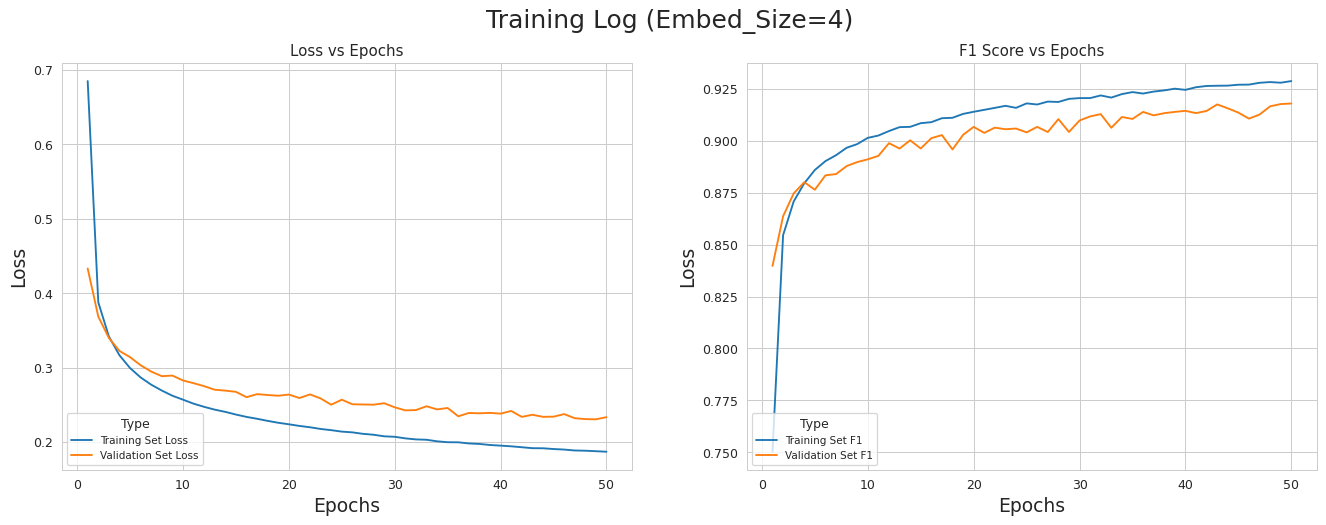

In [ ]:
# Define new model instance

USER_EMBED_SIZE = 4
NUM_CLASS = 14
LOAD_MODEL_NAME = 'UserEmbed_Super_4'
context_feat_size = data_df.shape[1]-2

UserEmbed_Super_4 = UserEmbedding(user_list_size,
                            USER_EMBED_SIZE,
                            context_feat_size,
                            NUM_CLASS).to(device)

# Load model from Google Drive

UserEmbed_Super_4, best_epoch, best_loss_train, lowest_loss_val, best_F1_train, \
    best_F1_val, epochs, total_losses_train, total_losses_val, total_F1_train, \
    total_F1_val = load_model(LOAD_MODEL_NAME, UserEmbed_Super_4)


# Save training log to dataframe format

train_loss_df = pd.DataFrame(zip(epochs, total_losses_train), columns=[
    'Epochs', 'Loss'])
train_loss_df['Type'] = 'Training Set Loss'
val_loss_df = pd.DataFrame(zip(epochs, total_losses_val), columns=[
    'Epochs', 'Loss'])
val_loss_df['Type'] = 'Validation Set Loss'
loss_df = pd.concat([train_loss_df, val_loss_df], axis=0)


train_f1_df = pd.DataFrame(zip(epochs, total_F1_train), columns=[
    'Epochs', 'F1'])
train_f1_df['Type'] = 'Training Set F1'
val_f1_df = pd.DataFrame(zip(epochs, total_F1_val), columns=[
    'Epochs', 'F1'])
val_f1_df['Type'] = 'Validation Set F1'
f1_df = pd.concat([train_f1_df, val_f1_df], axis=0)

# Visualise training log

train_log_visual(loss_df, f1_df, USER_EMBED_SIZE, best_epoch)

## 10.3 Load Model with USER_EMBED_SIZE=13

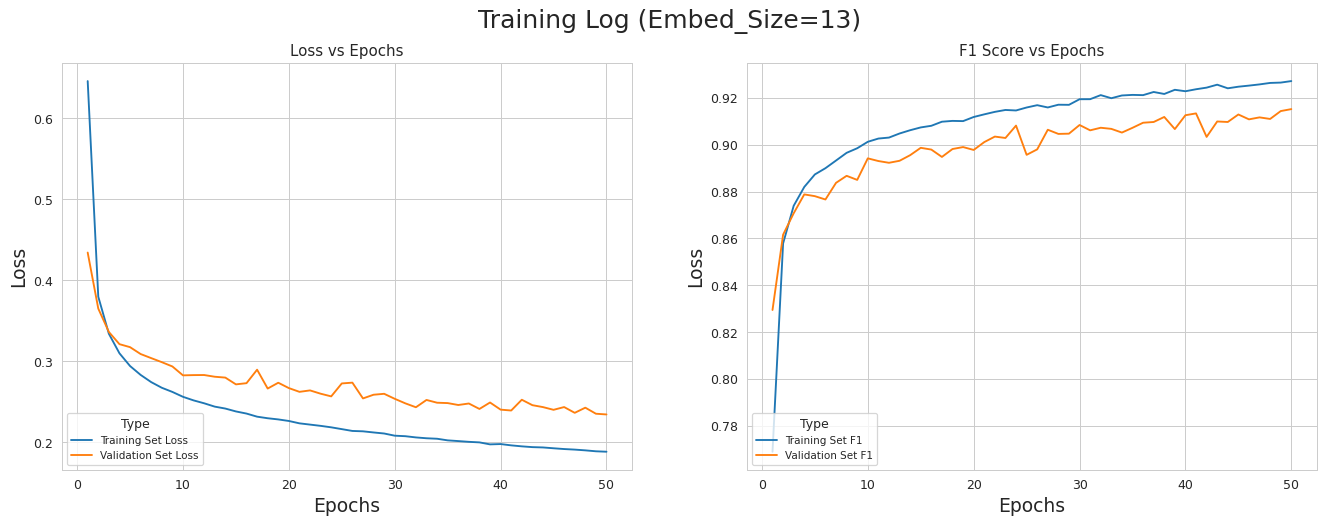

In [ ]:
# Define new model instance

USER_EMBED_SIZE = 13
NUM_CLASS = 14
LOAD_MODEL_NAME = 'UserEmbed_Super_13'
context_feat_size = data_df.shape[1]-2

UserEmbed_Super_13 = UserEmbedding(user_list_size,
                            USER_EMBED_SIZE,
                            context_feat_size,
                            NUM_CLASS).to(device)

# Load model from Google Drive

UserEmbed_Super_13, best_epoch, best_loss_train, lowest_loss_val, best_F1_train, \
    best_F1_val, epochs, total_losses_train, total_losses_val, total_F1_train, \
    total_F1_val = load_model(LOAD_MODEL_NAME, UserEmbed_Super_13)


# Save training log to dataframe format

train_loss_df = pd.DataFrame(zip(epochs, total_losses_train), columns=[
    'Epochs', 'Loss'])
train_loss_df['Type'] = 'Training Set Loss'
val_loss_df = pd.DataFrame(zip(epochs, total_losses_val), columns=[
    'Epochs', 'Loss'])
val_loss_df['Type'] = 'Validation Set Loss'
loss_df = pd.concat([train_loss_df, val_loss_df], axis=0)


train_f1_df = pd.DataFrame(zip(epochs, total_F1_train), columns=[
    'Epochs', 'F1'])
train_f1_df['Type'] = 'Training Set F1'
val_f1_df = pd.DataFrame(zip(epochs, total_F1_val), columns=[
    'Epochs', 'F1'])
val_f1_df['Type'] = 'Validation Set F1'
f1_df = pd.concat([train_f1_df, val_f1_df], axis=0)

# Visualise training log

train_log_visual(loss_df, f1_df, USER_EMBED_SIZE, best_epoch)

## 10.4 Load Model with USER_EMBED_SIZE=17

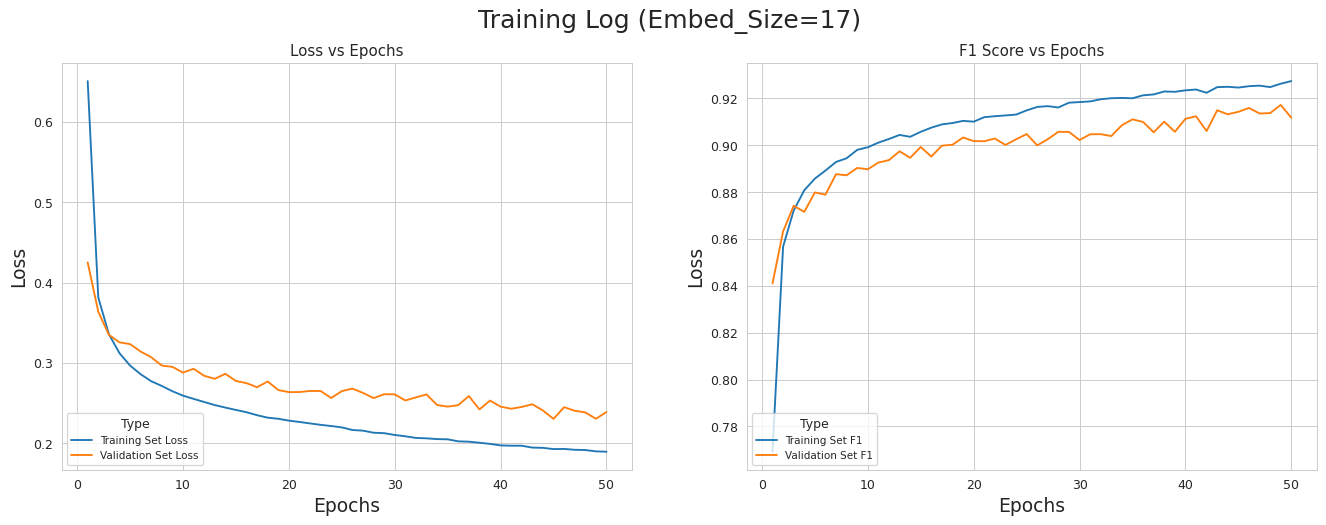

In [ ]:
# Define new model instance

USER_EMBED_SIZE = 17
NUM_CLASS = 14
LOAD_MODEL_NAME = 'UserEmbed_Super_17'
context_feat_size = data_df.shape[1]-2

UserEmbed_Super_17 = UserEmbedding(user_list_size,
                            USER_EMBED_SIZE,
                            context_feat_size,
                            NUM_CLASS).to(device)

# Load model from Google Drive

UserEmbed_Super_17, best_epoch, best_loss_train, lowest_loss_val, best_F1_train, \
    best_F1_val, epochs, total_losses_train, total_losses_val, total_F1_train, \
    total_F1_val = load_model(LOAD_MODEL_NAME, UserEmbed_Super_17)


# Save training log to dataframe format

train_loss_df = pd.DataFrame(zip(epochs, total_losses_train), columns=[
    'Epochs', 'Loss'])
train_loss_df['Type'] = 'Training Set Loss'
val_loss_df = pd.DataFrame(zip(epochs, total_losses_val), columns=[
    'Epochs', 'Loss'])
val_loss_df['Type'] = 'Validation Set Loss'
loss_df = pd.concat([train_loss_df, val_loss_df], axis=0)


train_f1_df = pd.DataFrame(zip(epochs, total_F1_train), columns=[
    'Epochs', 'F1'])
train_f1_df['Type'] = 'Training Set F1'
val_f1_df = pd.DataFrame(zip(epochs, total_F1_val), columns=[
    'Epochs', 'F1'])
val_f1_df['Type'] = 'Validation Set F1'
f1_df = pd.concat([train_f1_df, val_f1_df], axis=0)

# Visualise training log

train_log_visual(loss_df, f1_df, USER_EMBED_SIZE, best_epoch)

# 11. T-SNE Plot of Embedding Matrices

In [ ]:
def embed_visual(profile_df, embed_df, embed_name, perplexity=5):

    tmp_df = profile_df.join(embed_df.set_index(
        'userId'), how='left', on='userId').copy()

    num_comp = embed_df[embed_name][0].shape[0]

    if num_comp == 2:
        tmp_df['component_0'] = tmp_df.apply(
            lambda x: x[embed_name][0], axis=1)
        tmp_df['component_1'] = tmp_df.apply(
            lambda x: x[embed_name][1], axis=1)
        title = embed_name + \
            ' (Embedding Size = ' + str(num_comp) + ') Visualisation without T-SNE'
        xlabel = embed_name + ' component_0'
        ylabel = embed_name + ' component_1'

    elif num_comp > 2:
        tsne_obj = TSNE(n_components=2, verbose=0, perplexity=perplexity,
                        n_iter=1000, random_state=15)

        tsne_results = tsne_obj.fit_transform(
            np.stack(tmp_df[embed_name].to_numpy(), axis=0))

        tsne_user_df = pd.DataFrame(data=tsne_results,
                                    index=embed_df.userId, columns=['component_0', 'component_1'])

        tmp_df = tmp_df.join(tsne_user_df, how='left', on='userId')

        title = embed_name + \
            ' (Embedding Size = ' + str(num_comp) + ') Visualisation with T-SNE'
        xlabel = embed_name + ' T-SNE component_0'
        ylabel = embed_name + ' T-SNE component_1'

    fig, axes = plt.subplots(1, 3, figsize=(24, 6), dpi=90)
    fig.suptitle(title, fontsize=20)

    for idx, feat in enumerate(['avg_calories', 'avg_speed', 'avg_distance']):
        sns.scatterplot(x='component_0',
                        y='component_1',
                        palette=sns.color_palette(
                            'rocket_r', as_cmap=True),
                        data=tmp_df,
                        hue=feat,
                        ax=axes[idx])

    for ax in axes:
        ax.set_xlabel(xlabel, fontsize=15)
        ax.set_ylabel(ylabel, fontsize=15)
        ax.legend(loc='lower left',
                  title=ax.get_legend().get_title().get_text(),
                  fontsize='small')

user_embed_df shape:  (929, 2)
userEmbed shape:  (2,)
userEmbed datatype:  <class 'numpy.ndarray'>


,userId,userEmbed
0,69,"[2.8203146, 0.0011287987]"


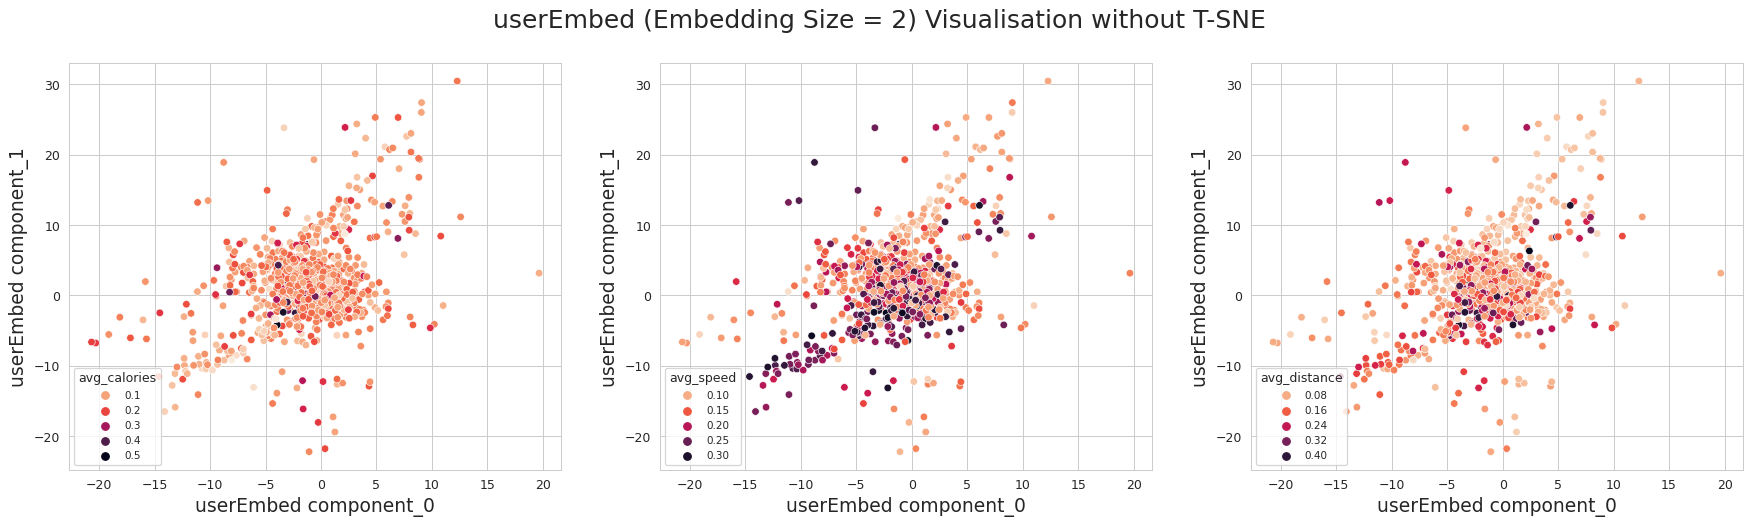

In [ ]:
# Produce userEmbed as dataframe

userId_idx = {userId: idx for idx, userId in enumerate(user_list)}

userId_Id_list = []
userEmbed_list = []

for _, (userId, user_idx) in enumerate(userId_idx.items()):
    embed_arr = UserEmbed_Super_2.user_embed_layer(
        torch.tensor(user_idx).to(device)).cpu().data.numpy()

    userId_Id_list.append(userId)
    userEmbed_list.append(embed_arr)


user_embed_df = pd.DataFrame(zip(userId_Id_list, userEmbed_list), columns=[
                             'userId', 'userEmbed'])

print('user_embed_df shape: ', user_embed_df.shape)
print('userEmbed shape: ', user_embed_df.userEmbed[0].shape)
print('userEmbed datatype: ', type(user_embed_df.userEmbed[0]))
display(user_embed_df.head(1))

# Visualise userEmbed with T-SNE

embed_visual(user_profile_df, user_embed_df, 'userEmbed', perplexity=5)

user_embed_df shape:  (929, 2)
userEmbed shape:  (4,)
userEmbed datatype:  <class 'numpy.ndarray'>


,userId,userEmbed
0,69,"[6.1493125, 0.68418086, -1.7089599, 2.4743693]"


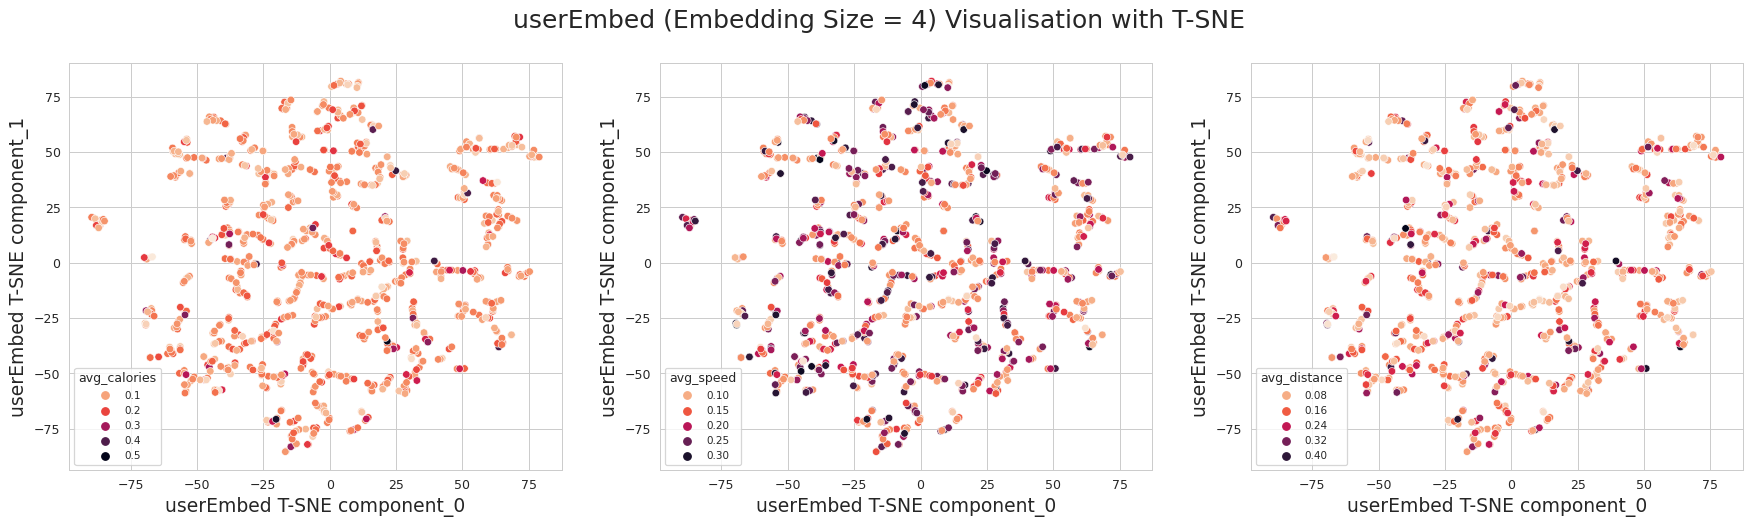

In [ ]:
# Produce userEmbed as dataframe

userId_idx = {userId: idx for idx, userId in enumerate(user_list)}

userId_Id_list = []
userEmbed_list = []

for _, (userId, user_idx) in enumerate(userId_idx.items()):
    embed_arr = UserEmbed_Super_4.user_embed_layer(
        torch.tensor(user_idx).to(device)).cpu().data.numpy()

    userId_Id_list.append(userId)
    userEmbed_list.append(embed_arr)


user_embed_df = pd.DataFrame(zip(userId_Id_list, userEmbed_list), columns=[
                             'userId', 'userEmbed'])

print('user_embed_df shape: ', user_embed_df.shape)
print('userEmbed shape: ', user_embed_df.userEmbed[0].shape)
print('userEmbed datatype: ', type(user_embed_df.userEmbed[0]))
display(user_embed_df.head(1))

# Visualise userEmbed with T-SNE

embed_visual(user_profile_df, user_embed_df, 'userEmbed', perplexity=5)

user_embed_df shape:  (929, 2)
userEmbed shape:  (13,)
userEmbed datatype:  <class 'numpy.ndarray'>


,userId,userEmbed
0,69,"[3.2115247, -1.5130085, 1.597315, 2.5455475, 3..."


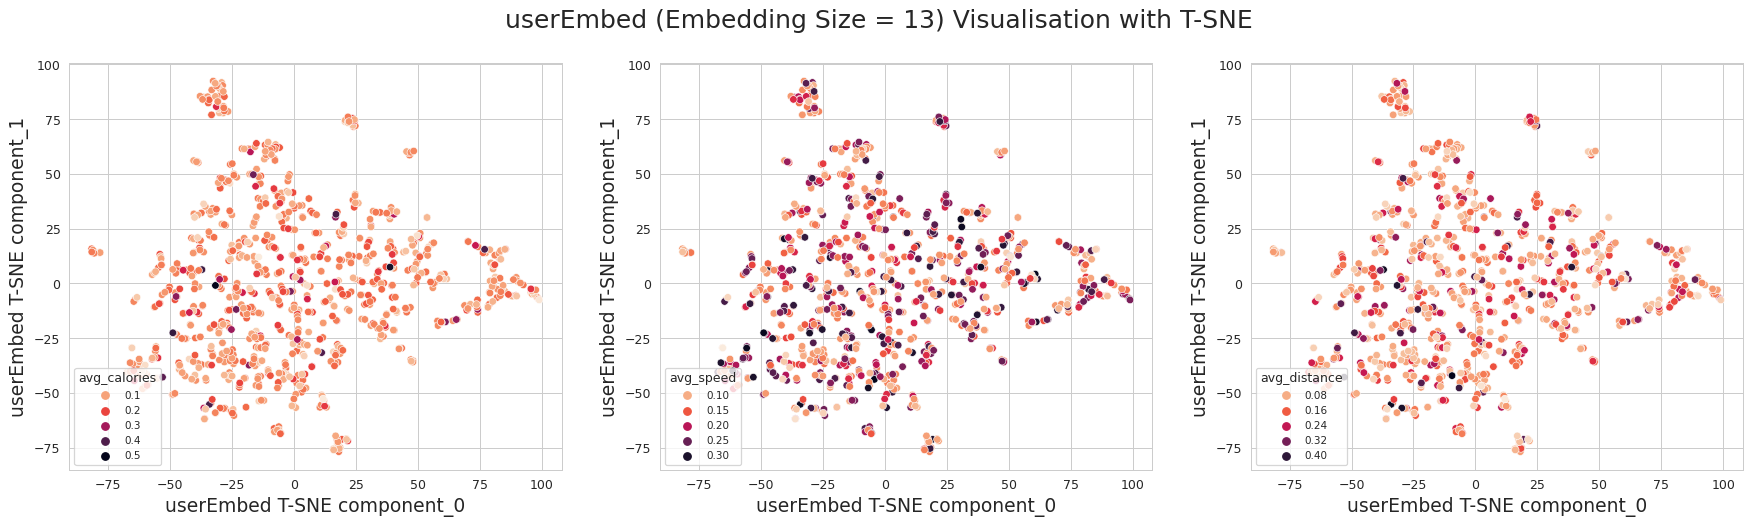

In [ ]:
# Produce userEmbed as dataframe

userId_idx = {userId: idx for idx, userId in enumerate(user_list)}

userId_Id_list = []
userEmbed_list = []

for _, (userId, user_idx) in enumerate(userId_idx.items()):
    embed_arr = UserEmbed_Super_13.user_embed_layer(
        torch.tensor(user_idx).to(device)).cpu().data.numpy()

    userId_Id_list.append(userId)
    userEmbed_list.append(embed_arr)


user_embed_df = pd.DataFrame(zip(userId_Id_list, userEmbed_list), columns=[
                             'userId', 'userEmbed'])

print('user_embed_df shape: ', user_embed_df.shape)
print('userEmbed shape: ', user_embed_df.userEmbed[0].shape)
print('userEmbed datatype: ', type(user_embed_df.userEmbed[0]))
display(user_embed_df.head(1))

# Visualise userEmbed with T-SNE

embed_visual(user_profile_df, user_embed_df, 'userEmbed', perplexity=5)

user_embed_df shape:  (929, 2)
userEmbed shape:  (17,)
userEmbed datatype:  <class 'numpy.ndarray'>


,userId,userEmbed
0,69,"[1.7493919, -1.0967327, 2.6644967, 4.476108, 0..."


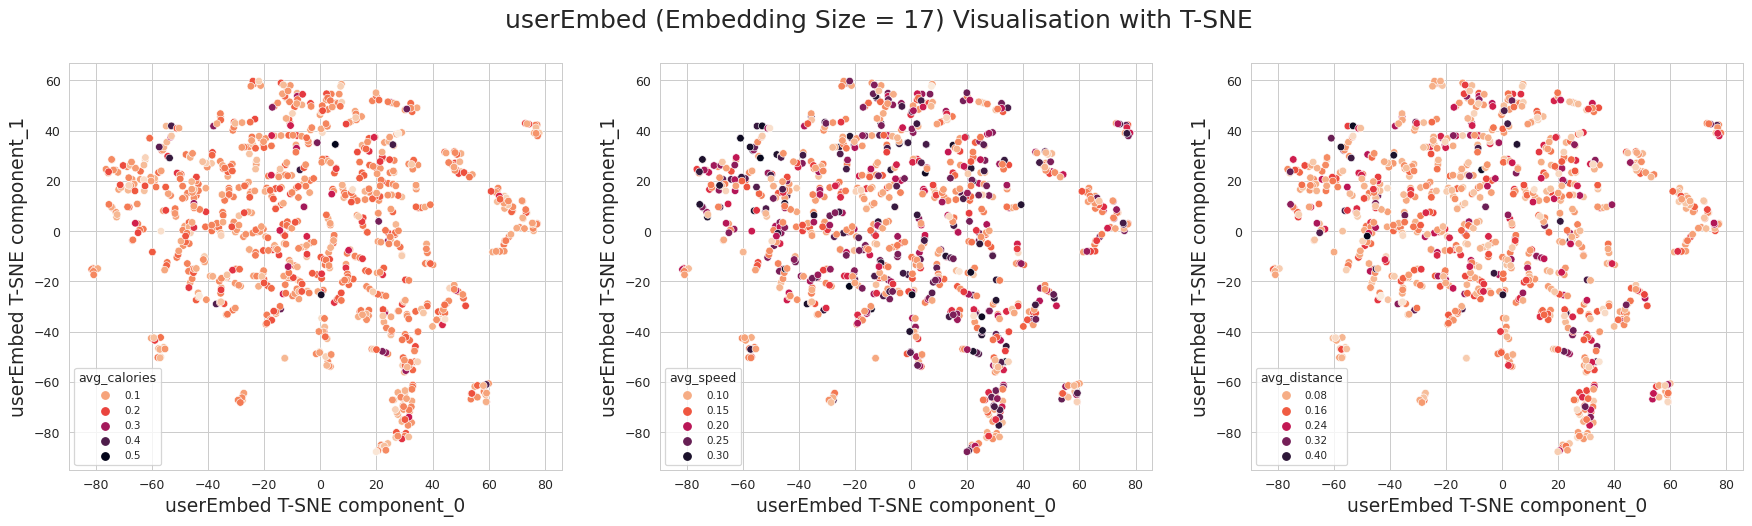

In [ ]:
# Produce userEmbed as dataframe

userId_idx = {userId: idx for idx, userId in enumerate(user_list)}

userId_Id_list = []
userEmbed_list = []

for _, (userId, user_idx) in enumerate(userId_idx.items()):
    embed_arr = UserEmbed_Super_17.user_embed_layer(
        torch.tensor(user_idx).to(device)).cpu().data.numpy()

    userId_Id_list.append(userId)
    userEmbed_list.append(embed_arr)


user_embed_df = pd.DataFrame(zip(userId_Id_list, userEmbed_list), columns=[
                             'userId', 'userEmbed'])

print('user_embed_df shape: ', user_embed_df.shape)
print('userEmbed shape: ', user_embed_df.userEmbed[0].shape)
print('userEmbed datatype: ', type(user_embed_df.userEmbed[0]))
display(user_embed_df.head(1))

# Visualise userEmbed with T-SNE

embed_visual(user_profile_df, user_embed_df, 'userEmbed', perplexity=5)

# 12. Save decomposed User Embedding

In [ ]:
# Save userEmbed as dataframe

userId_idx = {userId: idx for idx, userId in enumerate(user_list)}

userId_Id_list = []
userEmbed_list = []

for _, (userId, user_idx) in enumerate(userId_idx.items()):
    embed_arr = UserEmbed_Super_13.user_embed_layer(
        torch.tensor(user_idx).to(device)).cpu().data.numpy()

    userId_Id_list.append(userId)
    userEmbed_list.append(embed_arr)


user_embed_df = pd.DataFrame(zip(userId_Id_list, userEmbed_list), columns=[
                             'userId', 'userEmbed'])

print('user_embed_df shape: ', user_embed_df.shape)
print('userEmbed shape: ', user_embed_df.userEmbed[0].shape)
print('userEmbed datatype: ', type(user_embed_df.userEmbed[0]))
display(user_embed_df.head(1))

user_embed_df shape:  (929, 2)
userEmbed shape:  (13,)
userEmbed datatype:  <class 'numpy.ndarray'>


,userId,userEmbed
0,69,"[3.2115247, -1.5130085, 1.597315, 2.5455475, 3..."


In [ ]:
# Save Embedding

file_path = '/content/drive/My Drive/Colab Notebooks/DATA5703/Entity Embedding/userEmbed_Super.m'

joblib.dump(user_embed_df, file_path)


# Load Embedding

user_embed_df = joblib.load(file_path)